In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from dynamicalsystems import solve_rk4, lorenz63
sys.path.append('../')
from esn.utils import errors, scalers
from esn.validation import validate, set_ESN
from esn.esn import ESN
import jax
jax.config.update("jax_enable_x64", True)
from jax import numpy as jnp
import jax_esn.esn as jesn
from jax_esn.esn import ESN as JESN

# Generate the data:
Solve the Lorenz 63 system using RK4. The parameters and inital condition are selected to ensure the system is chaotic. 

In [2]:
dim = 3
# Parameters to ensure the system is chaotic
params = [2.667, 28, 10]  # beta, rho, sigma
u0 = np.array([0.0, 1.0, 1.0])  # initial condition

dt = 0.01  # time step
t_lyap = 0.9**(-1)  # Lyapunov time

N_lyap = int(t_lyap/dt)
N_trans = 2000  # initial transient to discard
N_total = 500*N_lyap + N_trans
time_array, U_rk4, derU = solve_rk4(lorenz63, N_total, dt, u0=u0, params=params)
U_rk4 = U_rk4[N_trans:]  # remove the initial transient

Prepare the training, validation and test data. Allow for a washout phase in the reservoir. 

In [3]:
# set sizes
washout_size = 100
train_size = 10000
val_size = 5000
test_washout_size = 100

# Extract the shape of the original data
total_samples, num_features = U_rk4.shape

# Split the data into different datasets
U_washout = U_rk4[:washout_size, :]
U_train_input = U_rk4[washout_size:washout_size + train_size, :]
U_train_label = U_rk4[washout_size + 1: washout_size + train_size + 1, :]
U_val_input = U_rk4[washout_size + train_size: washout_size + train_size + val_size, :]
U_val_label = U_rk4[washout_size + train_size + 1: washout_size + train_size + val_size + 1, :]
U_test_washout = U_rk4[washout_size + train_size + val_size:washout_size + train_size + val_size + test_washout_size, :]
U_test = U_rk4[washout_size + train_size + val_size + test_washout_size:, :]

# Print shapes of datasets
print(f"Training data shape: {U_train_input.shape}")
print(f"U_val shape: {U_val_input.shape}")
print(f"U_test shape: {U_test.shape}")

Training data shape: (10000, 3)
U_val shape: (5000, 3)
U_test shape: (40301, 3)


# Training and Validation of ESNs

In [4]:
# specify which hyperparameters to search, e.g., spectral_radius, input_scaling, leak_factor
param_names = ['spectral_radius', 'input_scaling','tikhonov']

# range for hyperparameters 
spec_in = 0.1
spec_end = 1.0
in_scal_in = 0.1
in_scal_end = 10.0
leak_in = 0.05
leak_end = 1.0
tikh_in = 1e-9
tikh_out= 1e-3
grid_range = [[spec_in, spec_end], [in_scal_in, in_scal_end], [tikh_in, tikh_out]]


# how to scale the search for each hyperparameter in the given range, uniform or in log10
param_scales = ['uniform', 'log10', 'log10']

# scale the ranges
for i in range(len(grid_range)):
    for j in range(2):
        scaler = getattr(scalers, param_scales[i])
        grid_range[i][j] = scaler(grid_range[i][j])

N_washout = washout_size # number of washout steps
N_val = int(0.5*N_lyap)  # number of validation steps, 1 or 0.5 LT is a good place to start

# if want to do a grid search first, simply pass in n_grid to the validation
# n_grid=[2]*len(param_names)

# Fixed properties of the ESN
# Fix the reservoir size, connectivity, input/output biases etc. here
# For smaller systems usually a reservoir size of 100-1200 is enough, with connectivity 3-20 

# In order to break the antisymmetry of tanh, sometimes it is necessary to add an input bias.
# When using an input bias, it is augmented to the input state vector.
# The input bias can either be connected to some reservoir variables in a sparse way, 
# similar to the input state, then use 'input_weights_mode': 'sparse_random'
# Or it can be connected to all reservoir variables, then use 'input_weights_mode': 'sparse_random_dense_input_bias'
# If the prediction doesn't perform well, it is worth exploring both options

ESN_dict = {'reservoir_size': 300,
            'dimension': dim,
            'reservoir_connectivity': 3,
            'input_weights_mode': 'sparse_random', # how the input weights are generated
            'input_bias': np.array([1.0]), # include an input bias if needed
            #'output_bias': np.array([1.0]), # include an output bias if needed, especially if removing the data mean
            }
# tikhonov = 1e-6

# min_dict contains the set of top five hyperparameters in terms of validation error
# and the error associated with them 
min_dict = validate(
    grid_range=grid_range, 
    param_names=param_names, 
    param_scales=param_scales, 
    n_calls=20, # number of total trials  
    n_initial_points=10, # number of initial trials before bayesian optimization
    ESN_dict=ESN_dict, 
    U_washout_train=U_washout,
    n_realisations=3, # number of random ESN realisations
    U_train=U_train_input,
    Y_train=U_train_label, 
    U_val=U_val_input,
    Y_val=U_val_label,
    n_folds=5, # number of folds, i.e., validation time series that start from random time instances 
    N_washout_steps=N_washout, 
    N_val_steps=N_val, 
    random_seed=20, # random seed for the bayesian optimization
    error_measure=errors.rmse, # error measure to optimize over
    n_grid=None) # grid search 

Input to run_gp:([Real(low=0.1, high=1.0, prior='uniform', transform='identity'), Real(low=-1.0, high=1.0, prior='uniform', transform='identity'), Integer(low=-9.0, high=-3.0, prior='uniform', transform='identity')], 20, 10, 20)
--NEW RUN-- 1
Realisation: 0
spectral_radius 0.6335601564025166
input_scaling 4.881255012149711
tikhonov 0.0001


Val regime: 0
Fold: 0 , fold error:  1376.1583355533198
Fold: 1 , fold error:  1404.5166513046506
Fold: 2 , fold error:  1418.0626773614774
Fold: 3 , fold error:  1362.516026346922
Fold: 4 , fold error:  8.682819759929275
Val regime error: 1113.9873020652597
Realisation error: 1113.9873020652597


Realisation: 1
spectral_radius 0.6335601564025166
input_scaling 4.881255012149711
tikhonov 0.0001


Val regime: 0
Fold: 0 , fold error:  2.4634155349555193
Fold: 1 , fold error:  14.977136599106718
Fold: 2 , fold error:  14.171837439027035
Fold: 3 , fold error:  5.135753064956602
Fold: 4 , fold error:  2.159519479272406
Val regime error: 7.7815324234636565

In [5]:
print("Top 5 hyperparameters:")
for hyp_idx in range(5):
    print_str = f'{hyp_idx+1}. '
    for param_name in min_dict.keys():
        if param_name != "f":
            if param_name == 'tikhonov':
                print_str += f"{param_name}: {min_dict[param_name][hyp_idx]:0.1e}  "
            else:
                print_str += f"{param_name}: {min_dict[param_name][hyp_idx]:0.4f}  "
    print_str += f" | Val. error: {min_dict['f'][hyp_idx]:0.5f}"
    print(print_str)

Top 5 hyperparameters:
1. spectral_radius: 0.3912  input_scaling: 0.1305  tikhonov: 1.0e-07   | Val. error: 0.00247
2. spectral_radius: 0.7828  input_scaling: 0.1629  tikhonov: 1.0e-06   | Val. error: 0.00323
3. spectral_radius: 0.3678  input_scaling: 0.1298  tikhonov: 1.0e-07   | Val. error: 0.00653
4. spectral_radius: 0.8096  input_scaling: 0.1615  tikhonov: 1.0e-06   | Val. error: 0.00918
5. spectral_radius: 1.0000  input_scaling: 0.1637  tikhonov: 1.0e-06   | Val. error: 0.00935


# Train the ESN with the best hyperparameter and predict on the test set

In [6]:
my_ESN = ESN(**ESN_dict,
             spectral_radius=min_dict['spectral_radius'][0],
             input_scaling=min_dict['input_scaling'][0],
             tikhonov=min_dict['tikhonov'][0],
             input_seeds=[0, 1, 2],
             reservoir_seeds=[3, 4])

my_ESN.train(U_washout, U_train_input, U_train_label)

reservoir, prediction = my_ESN.closed_loop_with_washout(U_test_washout, 10*N_lyap)

Input normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.


In [7]:
def plot_prediction(time_steps, U_test, prediction, N_plot, n_plot_vars=None, labels_plot_vars=None):
    """
    Plot the prediction of the ESN
    Args:
        time_steps: time units normalised by the Lyapunov time
        U_test: test data
        prediction: predicted data
        N_plot: number of time steps to plot
        n_plot_vars: number of state variables to plot, defaults to all 
    """
    # set the number of variables to plot
    if n_plot_vars is None:
        n_plot_vars = U_test.shape[1] 
    if labels_plot_vars is None:
        labels_plot_vars = [] * n_plot_vars
        for plot_var_idx in range(n_plot_vars):
            labels_plot_vars[plot_var_idx] = f"x_{plot_var_idx+1}"
        
    # Create a figure with three subplots
    fig, axes = plt.subplots(n_plot_vars, 1)

    for plot_var_idx in range(n_plot_vars):
        axes[plot_var_idx].plot(time_steps[:N_plot], U_test[:N_plot, plot_var_idx], color='black', label='Reference')
        axes[plot_var_idx].plot(time_steps[:N_plot], prediction[:N_plot, plot_var_idx], color='red', linestyle='dashed', label='ESN Prediction')
        axes[plot_var_idx].set_ylabel(labels_plot_vars[plot_var_idx])
        axes[plot_var_idx].set_xlabel("t [LT]")

    axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
    # Add a title for the entire figure
    fig.suptitle("Comparison of ESN Prediction and Reference - Test Data")
    # Adjust layout for better spacing
    plt.tight_layout()
    # Show the plot
    plt.show()

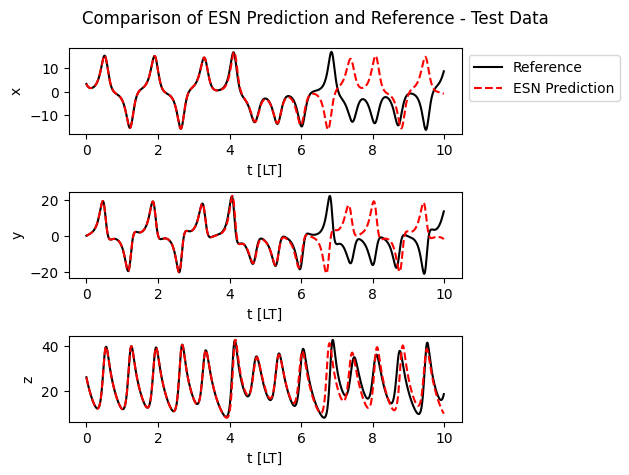

In [8]:
N_plot = 10 * N_lyap
# Define time steps
time_steps = np.arange(0, N_plot * dt, dt) / t_lyap
plot_prediction(time_steps, U_test, prediction, N_plot, n_plot_vars=3, labels_plot_vars=["x","y","z"])

# Statistical Predictions

In [9]:
import scipy.stats as stats 

def stats_lorenz63(factor):
    # Ys_t = closed_loop(factor-1, Xa1[-1], Wout, sigma_in, rho,epsilon)[0]
    
    _, Ys_t = my_ESN.closed_loop_with_washout(U_test_washout, factor)
    
    len_signal=len(Ys_t)
        
    # Calculate the integral of the kde between 10 and 20:
    xmin, xmax = -20, 20
    dist = 2000
    x = np.linspace(xmin,xmax,dist)
    
    fig, axs = plt.subplots(1,3)
    
    fig.suptitle('Probability Density Function (PDF)')

    fig.set_figheight(4)
    fig.set_figwidth(16)

    for i in range(dim):
        signal = U_rk4[:,i]
        signal_p  = Ys_t[-len_signal:,i] #predicted closed loop
        
        kde = stats.gaussian_kde(signal)
        kde_p = stats.gaussian_kde(signal_p)
            
        axs[i].plot(x,kde(x),color='black', label='Reference')
        axs[i].plot(x,kde_p(x), color='red', linestyle='dashed', label='ESN Prediction')
        axs[i].set_ylabel('PDF')
        axs[i].set_xlabel('$x$'+str(i+1)+'(m)')
        
        if i == dim-2: # The range is different for x3
            xmin, xmax = 0, 50
            dist = 2000
            x = np.linspace(xmin,xmax,dist)

    plt.legend()    
    
    return(Ys_t)


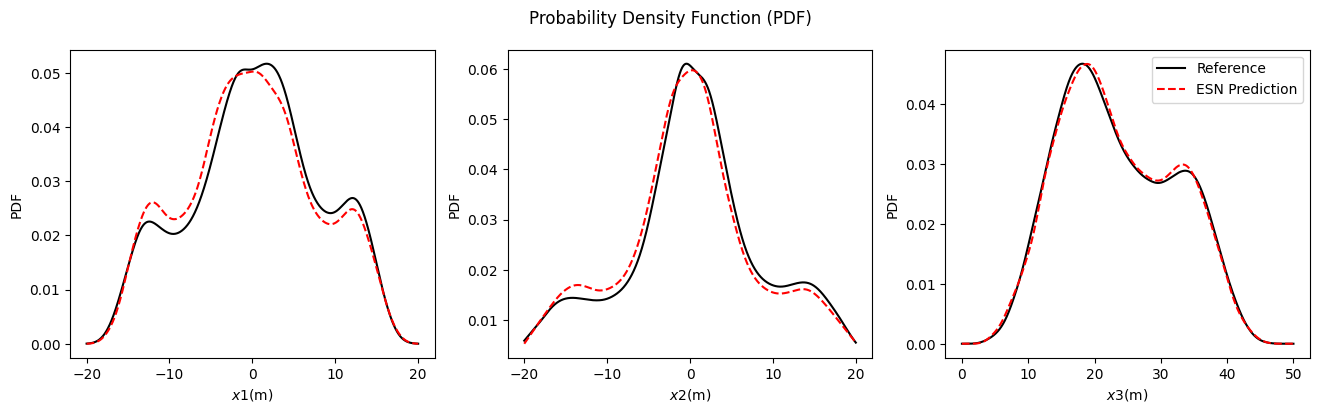

In [10]:
factor = 1000*N_lyap # How many lyapunov times to generate for statistical predictions
Ys_t = stats_lorenz63(factor)
plt.show()

## JAX implementation

In [11]:
# Create a JAX-ESN object with the same best hyperparameters
my_JESN = JESN(**ESN_dict,
             spectral_radius=min_dict['spectral_radius'][0],
             input_scaling=min_dict['input_scaling'][0],
             tikhonov=min_dict['tikhonov'][0],
             input_seeds=[0, 1, 2],
             reservoir_seeds=[3, 4])

Input normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.


In [12]:
# Train
W_out_jax = jesn.train(my_JESN, U_washout, U_train_input, U_train_label, my_JESN.tikh)

# Memory efficient training, uncomment if needed
# W_out_jax = jesn.train_mem(my_JESN, U_washout, U_train_input, U_train_label, my_JESN.tikh, 10) 

# VERY IMPORTANT! Train doesn't automatically update the weights of the object, so we have to set them manually
my_JESN.output_weights = W_out_jax

In [13]:
# Predict
reservoir, prediction = jesn.closed_loop_with_washout(my_JESN,U_test_washout, 10*N_lyap)

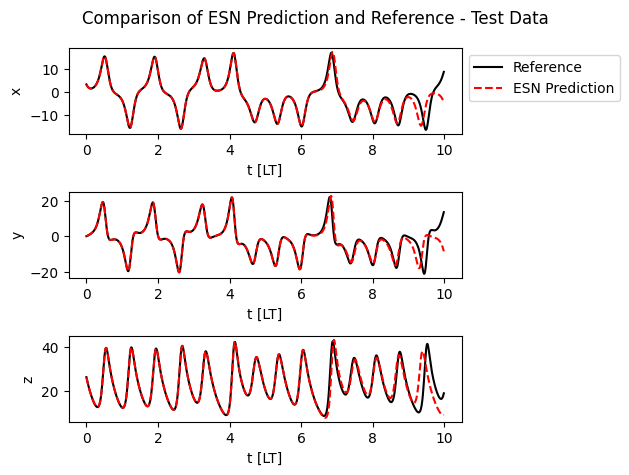

In [14]:
# Plot
N_plot = 10 * N_lyap
# Define time steps
time_steps = np.arange(0, N_plot * dt, dt) / t_lyap
plot_prediction(time_steps, U_test, prediction, N_plot, n_plot_vars=3, labels_plot_vars=["x","y","z"])